 # Processing Ultraviolet Images

In [1]:
import rawpy
import imageio
from matplotlib import pyplot as plt
import numpy as np

Below function opens the file path of a RAW image file and displays its three channels

In [3]:
def showChannels(path):
    raw = rawpy.imread(path).postprocess(output_bps=16)
    print(raw.shape)
    imageio.imsave((path[0:-4]+'.tiff'), raw)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

    axes[0][0].imshow(raw[...,0],cmap='Reds_r')
    axes[0][0].set_title('Red Values')

    axes[0][1].imshow(raw[...,1],cmap='Greens_r')
    axes[0][1].set_title('Green Values')

    axes[0][2].imshow(raw[...,2],cmap='Blues_r')
    axes[0][2].set_title('Blue Values')

    redCount,bins=np.histogram(raw[...,0])
    axes[1][0].hist(bins[:-1],bins,weights=redCount,color='Red')

    greenCount,bins=np.histogram(raw[...,1])
    axes[1][1].hist(bins[:-1],bins,weights=greenCount,color='Green')

    blueCount,bins=np.histogram(raw[...,2])
    axes[1][2].hist(bins[:-1],bins,weights=blueCount,color='Blue')

    fig.suptitle('RGB Channels for '+path)

    fig.tight_layout()

Demonstrating three separate examples with full spectrum (FS), ultraviolet (UV), RGB/Visible.

We can see that the full spectrum image is heavily red dominated, presumably because infrared light leans towards red on the spectrum and there's a great deal of infrared noise that the camera is capturing

(4040, 6064, 3)


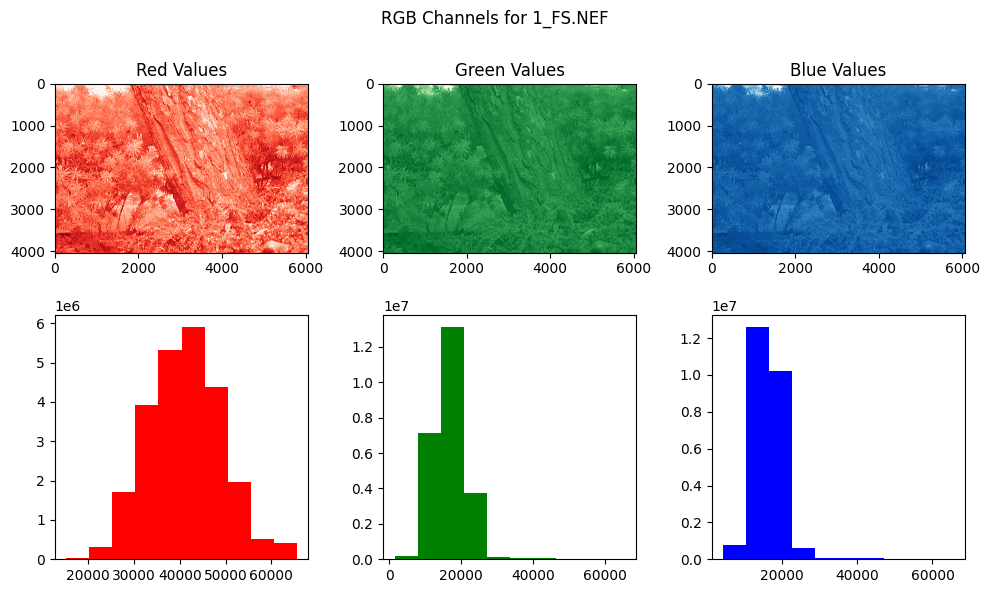

In [4]:
showChannels('1_FS.NEF')

Ultraviolet light is on the purple end of the light spectrum, so we can see the camera has largely split it up between red and blue (which allows us as humans to see purple)

(4040, 6064, 3)


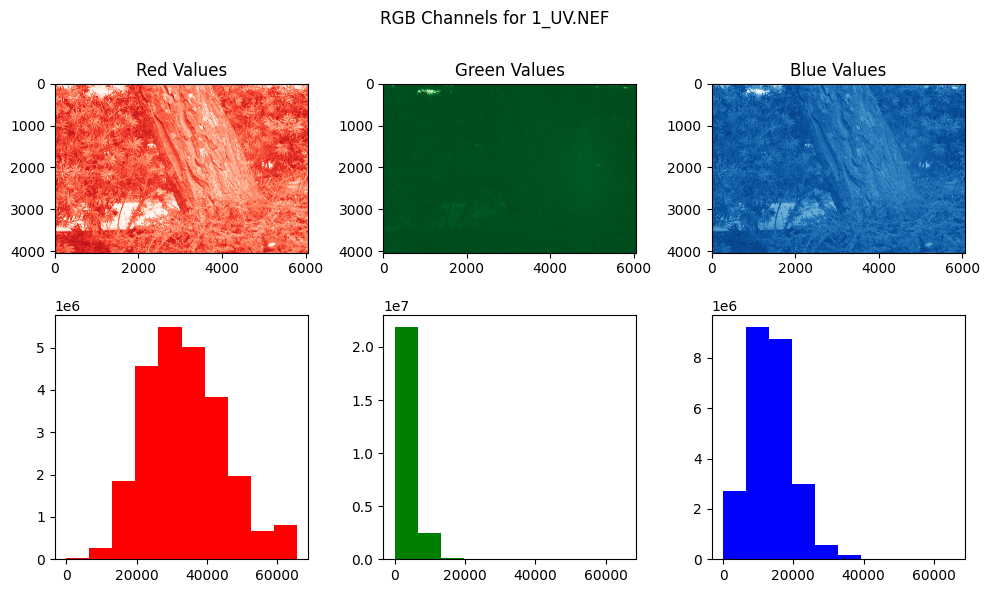

In [4]:
showChannels('1_UV.NEF')

Finally the visible light image has more green than the previous two, which is expected as humans' visible light is largely dominated by green

(4040, 6064, 3)


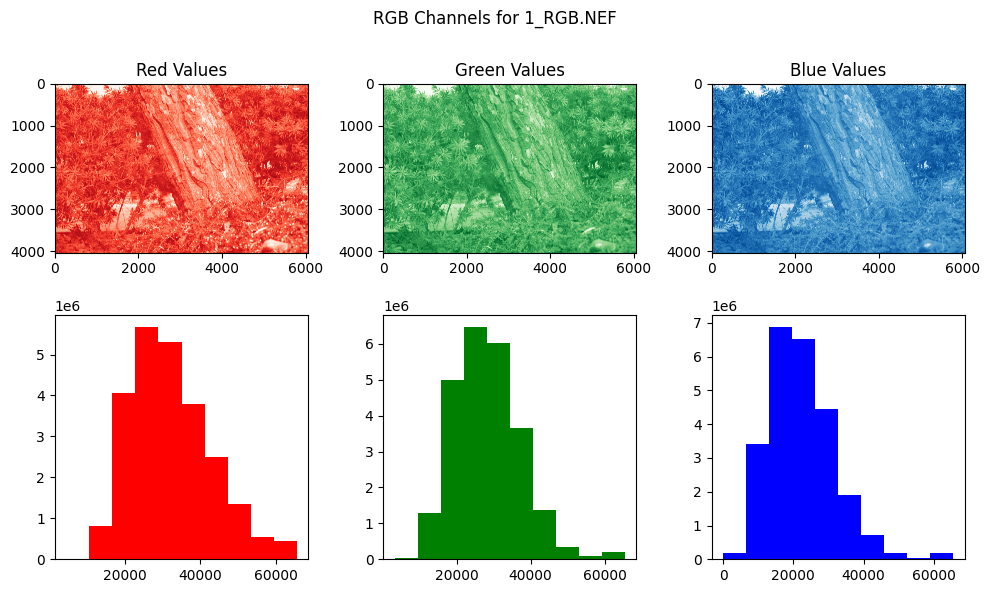

In [5]:
showChannels('1_RGB.NEF')

In [6]:
uv = rawpy.imread('1_UV.NEF').postprocess(output_bps=8)
fs = rawpy.imread('1_FS.NEF').postprocess(output_bps=8)
green = np.zeros((4040,6064), dtype=int)

Next we attempt to convert the ultraviolet image (which is split into two channels) into a single channel, containing all the necessary information stored in the red and blue channels. When converting images into grayscale, we use something called [Luma](https://en.wikipedia.org/wiki/Luma_%28video%29), which is denoted as:

$$L_{RGB} = 0.2126R + 0.7152G + 0.0722B$$

Here, we calculate an image's luminance (which is essentially its values on a grayscale) with a portion of each channel: red, green, and blue. We can see that Luma skews heavily towards using information from the green channel; this is because human vision is most sensitive to green, is relatively still quite sensitive to red, and is least sensitive to blue.

However, the ultraviolet image is largely split between red and blue with almost no information stored in green, so we instead normalize the $R$ and $B$ values and use them instead.

Then, our single channel UV image is composed of:
$$L_{UV} = R\frac{.2126}{.2126+.0722} + R\frac{.0722}{.2126+.0722} = 0.7465R + 0.2535B$$

Below you can see a comparison between using the 50/50 split vs. our adjusted Luma, and we can clearly see that the Luma creates a better image.

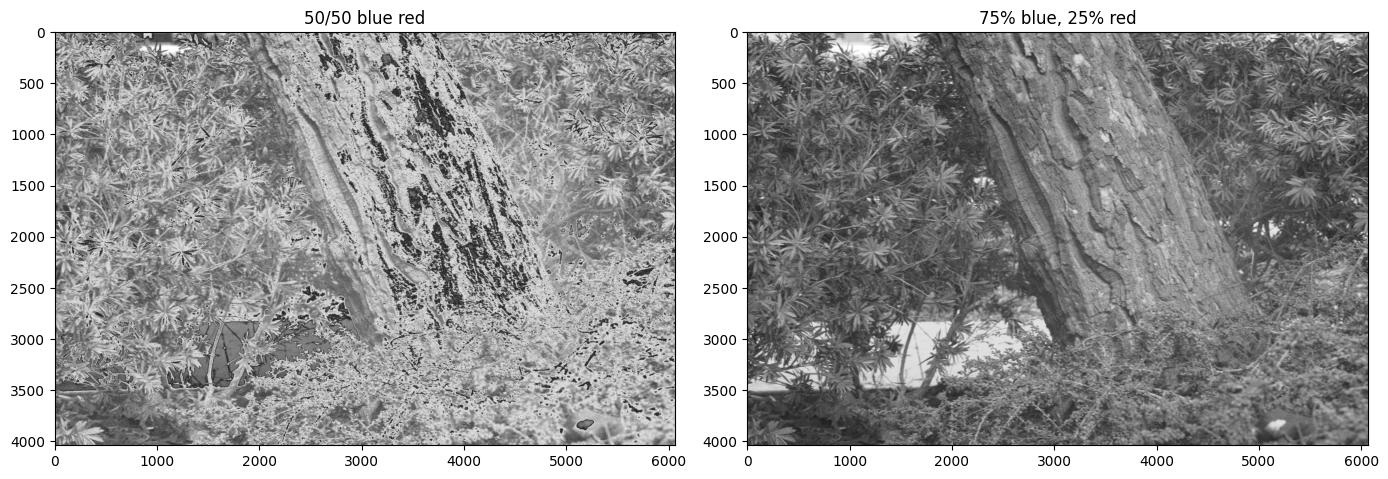

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

uv5050 = np.add(uv[...,0],uv[...,2])/2
axes[0].imshow(uv5050, cmap='gray')
axes[0].set_title('50/50 blue red')

uv7525 = np.add(uv[...,0] * 0.7465,uv[...,2] * 0.2535)
axes[1].imshow(uv7525, cmap='gray')
axes[1].set_title('75% blue, 25% red')

fig.tight_layout()

We also contemplated the possibility that all the information we require exists in one channel: that the red and blue channels are essentially identical after normalization. Below is some code that compares the normalized red and blue channels.

In [9]:
red = uv[...,0]
blue = uv[...,2]

In [10]:
def normalize(matrix):
    return ((matrix - np.average(matrix)) / np.std(matrix) * 75) + 100

In [37]:
def compareRedBlue(img):
    norm_red = normalize(img[...,0])
    norm_blue = normalize(img[...,2])
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

    # uv_img = np.add(uv[...,0] * 0.745,uv[...,2] * 0.255)
    axes[0].imshow(norm_red, cmap='gray')
    axes[0].set_title('Red normalized')

    axes[1].imshow(norm_blue, cmap='gray')
    axes[1].set_title('Blue normalized')

    uv_combined = np.add(uv[...,0] * 0.7465,uv[...,2] * 0.2535)
    axes[2].imshow(uv_combined, cmap='gray')
    axes[2].set_title('75% Blue, 25% Red combined image')

    fig.suptitle('Red and Blue channels normalized to std = 75, mean = 100')

    fig.tight_layout()

We can see below that this is not quite true; when we normalized both the red and blue channels to have mean 100 and stdev 75, we saw that there were some differences: notably, the red image is much brighter, but the blue one contains more detail that the red channel sometimes smears due to its high brightness. The combined image looks much better and clearer than any individual channel.

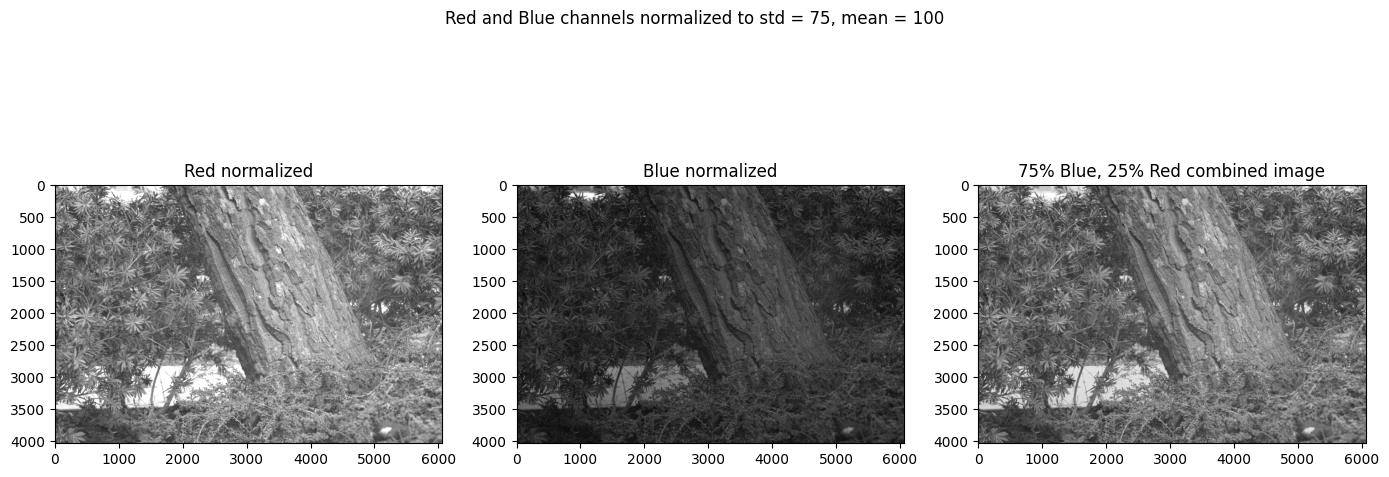

In [38]:
compareRedBlue(uv)